In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import tarfile
import matplotlib
import matplotlib.pyplot as plt
import keras as keras
from data_utils import read_files
from data_utils import *
import platform
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Using TensorFlow backend.


In [44]:
if platform.system() == 'Darwin':
    datafile_path = '/Users/anjalikarimpil/Google Drive/Dissertation/Data/Social LSTM/'
else:
    datafile_path = '/users/mscdsa2018/ask2/Projects/Data/Social LSTM'
# Get list of datafiles read
df_list, problem_list = read_files()


0
1


In [103]:
df = df_list[0].copy()

df['date'], df['time'] = df[0].str.split('T', 1).str
df[0] = pd.to_datetime(df[0], format="%Y-%m-%dT%H:%M:%S:%f")
df.columns = ['datetime', 'place', 'x_pos', 'y_pos', 'person_id', 'date', 'time']

In [104]:
df.sort_values(['person_id','datetime'], inplace=True, ascending=True)
df.reset_index()
df['time_lag'] = df.groupby(['person_id', 'date'])['datetime'].shift(1)
df['person_lag'] = df['person_id'].shift(1)


In [105]:
time_threshold = pd.to_timedelta('00:00:02.00000')
# flag 1 
df['fl_1'] = np.where((abs(df['time_lag'] - df['datetime']) > time_threshold) | (df['person_lag'] != df['person_id']), 1, 0)
df['traj_id'] = df['fl_1'].cumsum()


In [106]:
position_threshold = 500
df['x_lag'] = df.groupby(['traj_id'])['x_pos'].shift(1)
df['y_lag'] = df.groupby(['traj_id'])['y_pos'].shift(1)

df['x_diff'] = abs(df['x_pos'] - df['x_lag'])
df['y_diff'] = abs(df['y_pos'] - df['y_lag'])
df['fl_2'] = np.where((df['x_diff'] > position_threshold) | (df['y_diff'] > position_threshold), 1, 0)



In [116]:
df['fl_3'] = np.where((df['fl_1'] | df['fl_2']), 1, 0)

In [118]:
df['new_traj_id'] = df['fl_3'].cumsum()

In [124]:
df['x_lag'] = df.groupby(['new_traj_id'])['x_pos'].shift(1)
df['y_lag'] = df.groupby(['new_traj_id'])['y_pos'].shift(1)

df['x_diff'] = abs(df['x_pos'] - df['x_lag'])
df['y_diff'] = abs(df['y_pos'] - df['y_lag'])

In [125]:

df['x_diff'].describe()

count   4326044.00
mean         95.45
std          65.23
min           0.00
25%          41.00
50%         101.00
75%         132.00
max         500.00
Name: x_diff, dtype: float64

In [81]:
df.groupby(['traj_id']).agg({'x_diff': ['max'], 'y_diff': ['max']})


,x_diff,y_diff
,max,max
traj_id,,
1,1185.00,363.00
2,432.00,285.00
3,1108.00,457.00
4,1587.00,511.00
5,721.00,248.00
6,1385.00,1011.00
7,318.00,431.00
8,1929.00,705.00


In [82]:
df[df['x_diff'] == 1392.00]

,datetime,place,x_pos,y_pos,person_id,date,time,time_lag,person_lag,fl,traj_id,x_pos_next,y_pos_next,x_diff,y_diff
5406,2013-02-10 07:01:52.836,PIW,36752,12767,12,2013-02-10,07:01:52:836,2013-02-10 07:01:52.736,12.00,0,23,38144.00,12788.00,1392.00,21.00


In [84]:
df.loc[5404:5408,]

,datetime,place,x_pos,y_pos,person_id,date,time,time_lag,person_lag,fl,traj_id,x_pos_next,y_pos_next,x_diff,y_diff
5404,2013-02-10 07:01:52.636,PIW,36505,12815,12,2013-02-10,07:01:52:636,2013-02-10 07:01:52.536,12.00,0,23,36634.00,12789.00,129.00,26.00
5405,2013-02-10 07:01:52.736,PIW,36634,12789,12,2013-02-10,07:01:52:736,2013-02-10 07:01:52.636,12.00,0,23,36752.00,12767.00,118.00,22.00
5406,2013-02-10 07:01:52.836,PIW,36752,12767,12,2013-02-10,07:01:52:836,2013-02-10 07:01:52.736,12.00,0,23,38144.00,12788.00,1392.00,21.00
5407,2013-02-10 07:01:52.936,PIW,38144,12788,12,2013-02-10,07:01:52:936,2013-02-10 07:01:52.836,12.00,0,23,38329.00,12809.00,185.00,21.00
5408,2013-02-10 07:01:53.036,PIW,38329,12809,12,2013-02-10,07:01:53:036,2013-02-10 07:01:52.936,12.00,0,23,38395.00,12777.00,66.00,32.00


In [74]:
df_1[df_1['x_diff'] <= 200]

,datetime,place,x_pos,y_pos,person_id,date,time,time_lag,person_lag,fl,traj_id,x_pos_next,y_pos_next,x_diff,y_diff
1834915,2013-02-10 17:18:41.162,PIE,38805,41699,1906,2013-02-10,17:18:41:162,2013-02-10 17:18:41.062,1906.00,0,2741,45493.00,43082.00,-6688.00,-1383.00


In [11]:
# index = 1
# df_1 = df.loc[df['traj_id'] == index]
# plt.scatter(df_1['x_pos'], df_1['y_pos'])
# plt.show()

In [49]:
df_list[0].head(100).to_csv('sample.csv')

In [15]:

data = df[['traj_id','x_pos','y_pos']]
w = 20
for i in range(1, w + 1):
    data['x_'+str(i)] = data.groupby(['traj_id'])['x_pos'].shift(-i)
    data['y_'+str(i)] = data.groupby(['traj_id'])['x_pos'].shift(-i)
# Remove NAs 
data = data.dropna()

/users/mscdsa2018/ask2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/users/mscdsa2018/ask2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
data.head(5)

,traj_id,x_pos,y_pos,x_1,y_1,x_2,y_2,x_3,y_3,x_4,...,x_16,y_16,x_17,y_17,x_18,y_18,x_19,y_19,x_20,y_20
0,0,74446,5951,74441.00,74441.00,74440.00,74440.00,74440.00,74440.00,74438.00,...,74175.00,74175.00,74175.00,74175.00,74174.00,74174.00,74161.00,74161.00,74161.00,74161.00
1,0,74441,6066,74440.00,74440.00,74440.00,74440.00,74438.00,74438.00,74437.00,...,74175.00,74175.00,74174.00,74174.00,74161.00,74161.00,74161.00,74161.00,74162.00,74162.00
2,0,74440,6105,74440.00,74440.00,74438.00,74438.00,74437.00,74437.00,74449.00,...,74174.00,74174.00,74161.00,74161.00,74161.00,74161.00,74162.00,74162.00,74174.00,74174.00
3,0,74440,6108,74438.00,74438.00,74437.00,74437.00,74449.00,74449.00,74447.00,...,74161.00,74161.00,74161.00,74161.00,74162.00,74162.00,74174.00,74174.00,74184.00,74184.00
4,0,74438,6145,74437.00,74437.00,74449.00,74449.00,74447.00,74447.00,74431.00,...,74161.00,74161.00,74162.00,74162.00,74174.00,74174.00,74184.00,74184.00,74200.00,74200.00


In [26]:
from sklearn.model_selection import train_test_split
def dataset_generator(data):
    train = 0.8
    test = 0.2
#     dev = 0.1
    total_length = len(data)
    total_trajectories = np.ma.count(data['traj_id'].unique())
    train_ix = train * total_trajectories
    test_ix = test * total_trajectories
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 3:], data[['x_pos','y_pos']], 
                                                        train_size = 0.8, test_size = 0.2, random_state = 1)
    return X_train, X_test, y_train, y_test
#     dev_ix = dev * total_trajectories


In [1]:
# X_train, X_test, y_train, y_test = dataset_generator(data)
import data_utils
X_train, y_train, dev_X, dev_Y, X_test, y_test = data_utils.split_data()

In [35]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# X_train.reshape(shape = (-1, 10, 1 ))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

(3457436, 40) (864359, 40) (3457436, 2) (864359, 2)


In [36]:
X_train = X_train.reshape((-1, 2, w) )
X_test = X_test.reshape((-1, 2, w) )

In [2]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
w = 5

(3460780, 2, 5) (432598, 2, 5) (3460780, 2) (432598, 2)


In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import numpy as np


print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(2, w)))
model.add(Dense(2))

# try using different optimizers and different optimizer configs
model.compile(loss='mae',
              optimizer='adam',
              metrics=['accuracy'])



/users/mscdsa2018/ask2/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Build model...


In [4]:

print('Train...')
history = model.fit(X_train,y_train,epochs=25, batch_size = 64, validation_data=(X_test, y_test))

model.save('my_model.h5')

score = model.evaluate(X_test, y_test, batch_size=64)
print(score)

print('Predicting')
# predicted_output = model.predict(test_input, batch_size=72)

Train...
Train on 3460780 samples, validate on 432598 samples
Epoch 1/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 30860.3289 - acc: 0.2853 - val_loss: 29352.4973 - val_acc: 0.1689
Epoch 2/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 27763.9874 - acc: 0.1691 - val_loss: 26368.1039 - val_acc: 0.1689
Epoch 3/25
3460780/3460780 [==============================] - 191s 55us/step - loss: 24728.7902 - acc: 0.2913 - val_loss: 23164.8745 - val_acc: 0.1692
Epoch 4/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 21722.6004 - acc: 0.5221 - val_loss: 20697.6800 - val_acc: 0.8311
Epoch 5/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 19459.2739 - acc: 0.8309 - val_loss: 18726.0717 - val_acc: 0.8311
Epoch 6/25
3460780/3460780 [==============================] - 190s 55us/step - loss: 18220.8393 - acc: 0.8309 - val_loss: 17700.7415 - val_acc: 0.8311
Epoch 7/25
3460780/3460780 [====

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
None


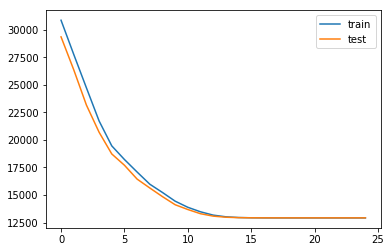

In [8]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [9]:
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 68,866
Trainable params: 68,866
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 2, 5)
Outputs: (None, 2)


In [43]:
model = keras.models.load_model('my_model.h5')

In [10]:
y_hat_test = model.predict(X_test)

In [11]:
y_hat_test.shape

(432598, 2)

In [12]:

dist = np.linalg.norm(y_hat_test-y_test, axis=1)

In [13]:

print(1/len(dist)*(np.sum(dist)))


22346.765945448784
